In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import dice_ml
from dice_ml.utils import helpers # helper functions
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import load_model   # load saved model
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt 
import sys; sys.path.insert(0, '../src/') 
import necsuf_tabular_text as nec_suf
import recourse_experiment as recourse_exp
import numpy as np
import seaborn as sns
from pathlib import Path
import json
import pickle
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [11]:
!python3 -m pip freeze | grep tensorflow
# !python3 -m pip install dice_ml==0.11
!python3 -m pip install tensorflow==0.111111


tensorflow==2.16.1
tensorflow-io-gcs-filesystem==0.36.0
ERROR: Could not find a version that satisfies the requirement tensorflow==0.111111 (from versions: 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.1, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==0.111111


### Follow initial steps from DiCE
**note: this notebook was run from a virtual environment with tensorflow v1, as it is more compatible with DiCE's implementation. Although the authors provide an extension to be used with tensorflow v2, in practice we still ran into errors unless running from a tensorflow v1 environment**

In [4]:
dataset = helpers.load_adult_income_dataset()

This dataset has 8 features. The outcome is income which is binarized to 0 (low-income, <=50K) or 1 (high-income, >50K). 

In [5]:
# description of transformed features
adult_info = helpers.get_adult_data_info()

In [6]:
d = dice_ml.Data(dataframe=dataset, continuous_features=['age', 'hours_per_week'], outcome_name='income')

In [7]:
backend = 'TF'+tf.__version__[0] # TF1
ML_modelpath = helpers.get_adult_income_modelpath(backend=backend)
m = dice_ml.Model(model_path= ML_modelpath, backend=backend)

Generate diverse counterfactuals

In [8]:
# initiate DiCE
exp = dice_ml.Dice(d, m)

TypeError: Error when deserializing class 'Dense' using config={'name': 'dense', 'trainable': True, 'dtype': 'float32', 'units': 20, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None, 'dtype': 'float32'}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}}, 'kernel_regularizer': {'class_name': 'L1L2', 'config': {'l1': 0.0010000000474974513, 'l2': 0.0}}, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'input_shape': [None, 29]}.

Exception encountered: <class 'keras.src.initializers.random_initializers.GlorotUniform'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None, 'dtype': 'float32'}, 'registered_name': None}.

Exception encountered: GlorotUniform.__init__() got an unexpected keyword argument 'dtype'

Use DiCE's initial example

In [7]:
# query instance in the form of a dictionary; keys: feature name, values: feature value
query_instance = {'age':22., 
                  'workclass':'Private', 
                  'education':'HS-grad', 
                  'marital_status':'Single', 
                  'occupation':'Service',
                  'race': 'White', 
                  'gender':'Female', 
                  'hours_per_week': 45.}

In [8]:
inp_raw = pd.DataFrame.from_dict(query_instance, orient='index').T
inp_raw

age workclass education marital_status occupation   race  gender  \
0  22.0   Private   HS-grad         Single    Service  White  Female   

  hours_per_week  
0           45.0

### Comparison with our framework

Using DiCE's pretrained MLP model

In [9]:
dice_model = load_model('../datasets/models/adult.h5')

In [10]:
prepared_df = pd.read_csv("../datasets/adult_clean.csv")
prepared_df.drop(["Unnamed: 0"], axis=1, inplace=True)

Load dataset post-encoding

In [11]:
prepared_df_listed = pd.read_csv("../datasets/adult_clean_listed.csv")
prepared_df_listed.drop(["Unnamed: 0"], axis=1, inplace=True)

categorical_cols = ['workclass', 'education', 'marital_status', 'occupation', 'race', 'gender']
cont_cols = ['age', 'hours_per_week']

for c in prepared_df_listed.columns:
    prepared_df_listed[c] = prepared_df_listed[c].apply(lambda x: np.array(eval(x)) 
                                                        if not (isinstance(x, int)|isinstance(x, float)) else x)
    
for cat in categorical_cols:
    prepared_df_listed[cat] = prepared_df_listed[cat].apply(lambda x: str(list(x)))

prepared_df_listed = prepared_df_listed.rename(columns={"modelPred": "Model_pred"})

### Run 50 input experiment detailed in paper, section 5.3 (Diverse counterfactuals)

In [13]:
# this takes a while to run. Results stored, and you can access the src code
# results_comparison = recourse_exp.recourse_experiment_main(CF_condition=CF_condition, clf=dice_model, dataset=prepared_df_listed, 
#                                       dataset_raw=dataset, num_features=num_features, datatype='Dice', d=d, exp=exp, num_inp=50)

In [14]:
# pickle.dump(results_comparison, open("out/results_recourse_comparison.p","wb"))
results_comparison = pickle.load( open( "out/results_recourse_comparison.p", "rb" ) )

### Example in paper, Table 5

In [15]:
results_comparison['inps'][2]

age     workclass                 education   marital_status  \
16054  0.342466  [1, 0, 0, 0]  [0, 0, 0, 1, 0, 0, 0, 0]  [0, 0, 0, 1, 0]   

               occupation    race  gender  hours_per_week  Model_pred  
16054  [0, 0, 0, 0, 1, 0]  [0, 1]  [0, 1]        0.397959         0.0

In [16]:
dataset.loc[16054]

age                       42
workclass         Government
education            HS-grad
marital_status        Single
occupation           Service
race                   White
gender                  Male
hours_per_week            40
income                     1
Name: 16054, dtype: object

In [17]:
results_comparison['our_dfs'][2]

subset    degree                                             string  \
0           [2]  0.089918                 education [0, 0, 0, 0, 0, 1, 0, 0]   
1           [3]  0.948354                     marital_status [0, 1, 0, 0, 0]   
2        [4, 7]  0.001235  occupation  [0, 0, 0, 0, 0, 1], hours_per_week...   
3     [1, 4, 7]  0.002058  workclass      [0, 0, 1, 0], occupation  [0, 0...   
4  [0, 1, 4, 7]  0.001852  age       0.369863, workclass      [0, 0, 1, 0...   

   cardinality       cost  
0            1   1.000000  
1            1   1.000000  
2            2  19.333333  
3            3  12.666667  
4            4  12.200000

In [18]:
results_comparison['dice_dfs'][2]

age     workclass                 education   marital_status  \
0  1.000000  [1, 0, 0, 0]  [0, 0, 0, 0, 0, 1, 0, 0]  [0, 1, 0, 0, 0]   
1  0.315068  [1, 0, 0, 0]  [0, 0, 0, 0, 1, 0, 0, 0]  [0, 1, 0, 0, 0]   
2  0.575342  [0, 0, 0, 1]  [0, 0, 1, 0, 0, 0, 0, 0]  [0, 1, 0, 0, 0]   
3  0.369863  [1, 0, 0, 0]  [0, 0, 1, 0, 0, 0, 0, 0]  [0, 0, 0, 1, 0]   
4  0.342466  [1, 0, 0, 0]  [0, 0, 0, 0, 0, 1, 0, 0]  [0, 0, 0, 1, 0]   

           occupation    race  gender  hours_per_week       cost  \
0  [0, 0, 0, 0, 1, 0]  [0, 1]  [0, 1]        0.357143   8.133333   
1  [0, 0, 0, 0, 0, 1]  [0, 1]  [1, 0]        0.346939   5.866667   
2  [0, 0, 0, 0, 1, 0]  [0, 1]  [0, 1]        0.418367   5.366667   
3  [0, 0, 1, 0, 0, 0]  [0, 1]  [0, 1]        0.428571   3.200000   
4  [0, 0, 0, 0, 1, 0]  [0, 1]  [0, 1]        0.724490  11.666667   

               subset  
0        [0, 2, 3, 7]  
1  [0, 2, 3, 4, 6, 7]  
2     [0, 1, 2, 3, 7]  
3        [0, 2, 4, 7]  
4              [2, 7]

Cost comparison, as presented in the paper

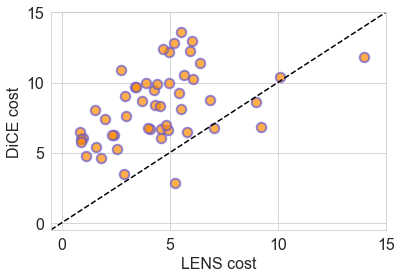

In [19]:
recourse_exp.plt_cost_comp(results_comparison, type='mean')

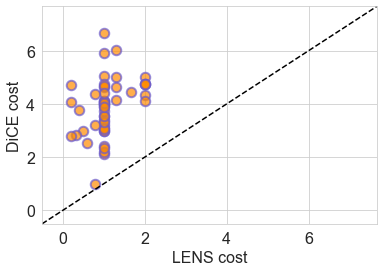

In [20]:
recourse_exp.plt_cost_comp(results_comparison, type='min')

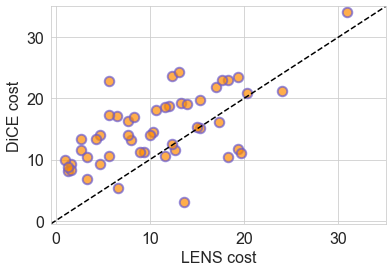

In [21]:
recourse_exp.plt_cost_comp(results_comparison, type='max')

Valid candidates comparison. Described in the text in 5.3, but figure not shown for its one-sidedness

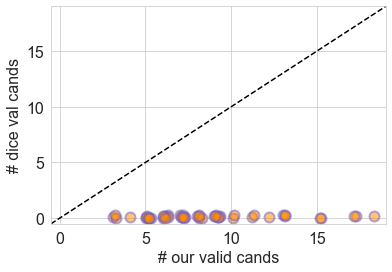

In [22]:
recourse_exp.plt_valid_cand(results_comparison)